# **Logistic Regression**

### **1. Get data**

In [26]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "15g") \
    .appName("Random Forest Model") \
    .getOrCreate()


In [27]:
# Read training data
train_df = spark.read.csv("data/train.csv", header=True, inferSchema=True)
train_df = train_df.drop("_c0")

# Read test data
# test_df = spark.read.csv("data/test.csv", header=True, inferSchema=True)
# test_df = test_df.drop("_c0")

train_df.show(5)

+----------+---------+--------+-------------+--------------------+-------------------+-------+------------------+---------------------+
|product_id|reordered|aisle_id|department_id|fav_aisle_aggregated|fav_dept_aggregated|cluster| avg_cart_position|avg_purchase_interval|
+----------+---------+--------+-------------+--------------------+-------------------+-------+------------------+---------------------+
|     33120|        0|      86|           16|                  24|                  4|      0|              11.0|                 11.2|
|     21903|        0|     123|            4|                  24|                  4|      0| 4.176470588235294|    8.941176470588236|
|     24852|        1|      24|            4|                  24|                  4|      0|4.6923076923076925|                10.92|
|     47766|        1|      24|            4|                  24|                  4|      0|               6.0|                  7.0|
|     35951|        0|      91|           16|   

In [28]:
print("Training Dataset Count: " + str(train_df.count()))
# print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 24142994


In [29]:
label_counts = train_df.groupBy("reordered").count()
label_counts.show()

+---------+--------+
|reordered|   count|
+---------+--------+
|        1|14492645|
|        0| 9650349|
+---------+--------+



#### 1.1. Split train_df into train and validation data

In [30]:
train_data, validation_data = train_df.randomSplit([0.8, 0.2], seed=42)

print("Training Dataset Count: " + str(train_data.count()))
print("Validation Dataset Count: " + str(validation_data.count()))

Training Dataset Count: 19313049


Validation Dataset Count: 4829945


### **2. Data Preprocessing**

In [31]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [32]:
numeric_features = ["avg_cart_position", "avg_purchase_interval"]
categorical_features = ["product_id", "aisle_id", "department_id", "fav_aisle_aggregated", "fav_dept_aggregated", "cluster"]

#### 2.1. Build Pipeline and Fit

In [33]:
'''
    Indexing categorical columns:
    - The indexer assigns a unique index to each category based on 
        the frequency of the category appearing in the dataset 
        (most frequent category gets index 0)
'''

indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_indexed", handleInvalid="keep")
    for column in categorical_features
]
# for indexer in indexers:
#     sample_df = indexer.fit(sample_df).transform(sample_df)
#     sample_df.show()

In [34]:
'''
    Encoding categorical columns:
    - OneHotEncoder (PySpark transformer): convert each index of a categorical feature into 
        a binary vector with at most a single one-value indicating the presence of 
        a specific feature value from among the set of all feature values.
'''

# encoder = OneHotEncoder(
#     inputCols=[indexer.getOutputCol() for indexer in indexers],
#     outputCols=[f"{column}_encoded" for column in categorical_features]
# )

# sample_df = encoder.fit(sample_df).transform(sample_df)
# sample_df.show()

'\n    Encoding categorical columns:\n    - OneHotEncoder (PySpark transformer): convert each index of a categorical feature into \n        a binary vector with at most a single one-value indicating the presence of \n        a specific feature value from among the set of all feature values.\n'

In [39]:
'''
    VectorAssembler: transformer that combines multiple columns of data into a single vector column
    Output: one column of all features
'''
num_assembler = VectorAssembler(inputCols=numeric_features, outputCol="num_features")

# sample_df = num_assembler.transform(sample_df)

'''
    Scaling numerical features
'''
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_numeric_features")

# scaler_model = scaler.fit(sample_df)
# sample_df = scaler_model.transform(sample_df)
# sample_df.show()

In [47]:
final_assembler = VectorAssembler(
    inputCols=[f"{column}_indexed" for column in categorical_features] + ["scaled_numeric_features"],
    outputCol="features"
)

# sample_df = final_assembler.transform(sample_df)
# sample_df.show()

In [48]:
# Pipeline: include indexer stages, encoder, num_assembler, scaler, and final_assembler
pipeline = Pipeline(stages=indexers + [num_assembler, scaler, final_assembler])

In [49]:
# Fit pipeline to training data
pipeline_model = pipeline.fit(train_data)

In [50]:
# Transform both training and validation data using the fitted pipeline model
train_transformed = pipeline_model.transform(train_data)
validation_transformed = pipeline_model.transform(validation_data)

In [51]:
train_transformed.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- fav_aisle_aggregated: integer (nullable = true)
 |-- fav_dept_aggregated: integer (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- avg_cart_position: double (nullable = true)
 |-- avg_purchase_interval: double (nullable = true)
 |-- product_id_indexed: double (nullable = false)
 |-- aisle_id_indexed: double (nullable = false)
 |-- department_id_indexed: double (nullable = false)
 |-- fav_aisle_aggregated_indexed: double (nullable = false)
 |-- fav_dept_aggregated_indexed: double (nullable = false)
 |-- cluster_indexed: double (nullable = false)
 |-- num_features: vector (nullable = true)
 |-- scaled_numeric_features: vector (nullable = true)
 |-- features: vector (nullable = true)



#### 2.2. Fit Random Forest Model

In [52]:
from pyspark.ml.classification import RandomForestClassifier
import numpy as np

In [55]:
rf = RandomForestClassifier(featuresCol='features', labelCol='reordered', numTrees=100, maxBins=50000)

In [56]:
# Fit initial model
rf_model = rf.fit(train_transformed)

24/06/05 15:37:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/05 15:37:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/05 15:38:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/06/05 15:40:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/06/05 15:40:52 WARN MemoryStore: Not enough space to cache rdd_352_4 in memory! (computed 509.3 MiB so far)
24/06/05 15:40:52 WARN BlockManager: Persisting block rdd_352_4 to disk instead.
24/06/05 15:40:52 WARN MemoryStore: Not enough space to cache rdd_352_3 in memory! (computed 509.3 MiB so far)
24/06/05 15:40:52 WARN BlockManager: Persisting block rdd_352_3 to disk instead.
24/06/05 15:40:52 WARN MemoryStore: Not enough space to cache rdd_352_0 in memory! (computed 509.3 MiB so far)
24/06/05 15:40:52 WARN BlockManager: Persisting block rdd_352_0 to disk instead.
24/06/05 15:40:52 WARN MemoryStore: Not enough space to cache rdd_352_7 in memor

In [57]:
predictions = rf_model.transform(validation_transformed)

In [58]:
print(predictions.count())
predictions.select(["reordered", "prediction"]).show(10)

4829945


24/06/05 19:03:05 WARN DAGScheduler: Broadcasting large task binary with size 66.8 MiB


+---------+----------+
|reordered|prediction|
+---------+----------+
|        1|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       0.0|
|        0|       1.0|
|        0|       1.0|
+---------+----------+
only showing top 10 rows



#### Evaluation

24/06/05 19:03:28 WARN DAGScheduler: Broadcasting large task binary with size 66.8 MiB
24/06/05 19:06:06 WARN DAGScheduler: Broadcasting large task binary with size 66.8 MiB


AUC-ROC: 0.7579
Accuracy: 0.7148
Precision: 0.7063
Recall: 0.8984


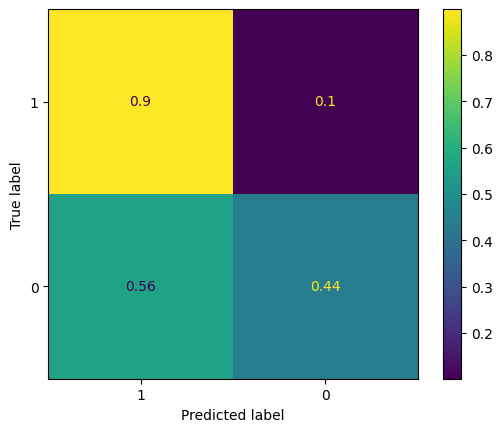

In [59]:
# Ensure all necessary imports
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate model
binary_evaluator = BinaryClassificationEvaluator(labelCol="reordered")
auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Confusion matrix
class_temp = predictions.select("reordered").groupBy("reordered").count().sort('count', ascending=False).toPandas()
class_names = class_temp["reordered"].values.tolist()

y_true = predictions.select("reordered").toPandas()["reordered"].to_numpy()
y_pred = predictions.select("prediction").toPandas()["prediction"].to_numpy()

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Multiclass classification evaluator for other metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Display confusion matrix in percent rate
cm = confusion_matrix(y_true, y_pred, labels=class_names, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()


#### Features Importances

In [62]:
feature_importances = rf_model.featureImportances
feature_names = final_assembler.getInputCols()

feature_importance_list = [(feature, importance) for feature, importance in zip(feature_names, feature_importances)]
feature_importance_list  = sorted(feature_importance_list, key=lambda x: abs(x[1]), reverse=True)
for feature, importance in feature_importance_list:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: cluster_indexed, Importance: 0.3303
Feature: product_id_indexed, Importance: 0.1131
Feature: scaled_numeric_features, Importance: 0.0714
Feature: department_id_indexed, Importance: 0.0532
Feature: aisle_id_indexed, Importance: 0.0328
Feature: fav_aisle_aggregated_indexed, Importance: 0.0001
Feature: fav_dept_aggregated_indexed, Importance: 0.0001


In [30]:
# import lime.lime_tabular # type: ignore
# import pandas as pd

# from pyspark.ml.linalg import DenseVector
# from pyspark.sql import Row

# def predict_fn(data):
#     # Convert the numpy array to a Spark DataFrame
#     df = spark.createDataFrame([Row(features=DenseVector(row)) for row in data.tolist()])

#     # Transform the DataFrame using the trained model
#     predictions = rf_model.transform(df)
#     print("done predictions")
    
#     # Extract the probability column as a numpy array
#     probs = predictions.select('probability').collect()
#     probs = np.array(probs).reshape(len(data),2)
#     return probs

# # Initialize LIME explainer
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     training_data=train_transformed.select('features').toPandas().to_numpy(),
#     feature_names=final_assembler.getInputCols(),
#     class_names=['Not Reordered', 'Reordered'],
#     mode='classification'
# )

# # Select an instance to explain
# instance = validation_transformed.select('features').collect()[0][0]
# print("instance: ", instance)

# # Explain the instance
# exp = explainer.explain_instance(
#     data_row=instance,
#     predict_fn=predict_fn
# )

# # Display the explanation
# # exp.show_in_notebook()
# print(exp.as_list())
# exp.save_to_file('lime_explanation.html')

##### Save Model

In [63]:
import os

model_save_path = "model/rf1_model"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

In [64]:
try:
    rf_model.write().overwrite().save(model_save_path)
    print(f"Model saved successfully at {model_save_path}")
except Exception as e:
    print(f"Error saving the model: {e}")

24/06/05 19:18:57 WARN TaskSetManager: Stage 164 contains a task of very large size (7385 KiB). The maximum recommended task size is 1000 KiB.


Model saved successfully at model/rf1_model
